In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43608 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:44697 Dashboard: http://127.0.0.1:43608/status,Cluster Workers: 24 Cores: 168 Memory: 810.56 GB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

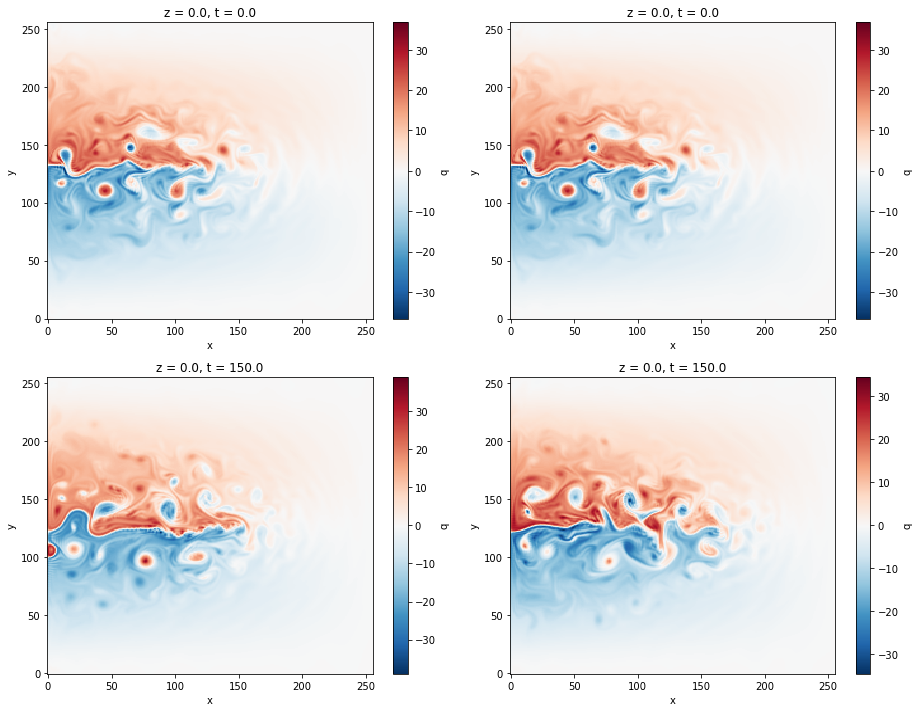

In [7]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

xr.open_dataset(op.join(ddir,'ctrl/vars.nc')).q.isel(t=0,z=0).plot(ax=axes[0,0])
xr.open_dataset(op.join(ddir,'run050/vars.nc')).q.isel(t=0,z=0).plot(ax=axes[0,1])
xr.open_dataset(op.join(ddir,'ctrl/vars.nc')).q.isel(t=150,z=0).plot(ax=axes[1,0])
xr.open_dataset(op.join(ddir,'run050/vars.nc')).q.isel(t=150,z=0).plot(ax=axes[1,1])

In [4]:
U = .1
tau = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 1500.
# f0 = 8e-5
beta = .5
N = 256    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002
ntime = 187

percent = 20
nmemb = 100

# Ensemble mean

<xarray.Dataset>
Dimensions:  (XC: 256, XG: 256, YC: 256, YG: 256, Z: 3, Zp1: 4, nmemb: 101, time: 187)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XG       (XG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YG       (YG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * Z        (Z) float64 0.03 0.13 0.6
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drC      (Zp1) float64 0.03 0.1 0.47 0.4
    drF      (Z) float64 0.06 0.14 0.8
  * time     (time) float32 435.0 436.0 437.0 438.0 ... 618.0 619.0 620.0 621.0
Dimensions without coordinates: nmemb
Data variables:
    p        (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 10, 3, 128, 128), meta=np.ndarray>
    ptr0     (nmemb, time, Z, YC, XC) float32 dask.array<chunksize=(1, 10, 3, 128, 128), meta=np.ndarray>
    ptr1     (nmemb, time, Z, YC, XC) float32 dask.a

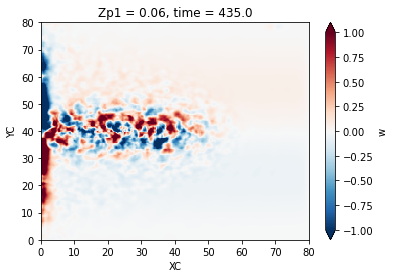

In [5]:
ntime = 187

for i in range(0,nmemb+1):
    if i < nmemb:
        if i == 0:
            ds = xr.open_zarr(op.join(ddir, 'run%02d/vars000' % i)).isel(time=slice(-ntime,None))
            dsw = xr.open_zarr(op.join(ddir, 'run%02d/W000' % i))
        else:
            ds = xr.concat([ds,xr.open_zarr(op.join(ddir, 'run%02d/vars000' % i)).isel(time=slice(-ntime,None))],
                           'nmemb')
            dsw = xr.concat([dsw,xr.open_zarr(op.join(ddir, 'run%02d/W000' % i))],
                            'nmemb')
    else:
        ds = xr.concat([ds,xr.open_zarr(op.join(ddir, 'ctrl/vars000')).isel(time=slice(-ntime,None))],
                       'nmemb')
        dsw = xr.concat([dsw,xr.open_zarr(op.join(ddir, 'ctrl/W000'))],
                        'nmemb')
print(ds)

grid = Grid(ds, periodic=[],
            coords={'Z':{'center':'Z','outer':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
psib = ds.p.mean('nmemb')
psip = ds.p - psib
up = -grid.diff(psip,'Y',boundary='fill') / dx
vp = grid.diff(psip,'X',boundary='fill') / dx
wb = dsw.w.mean('nmemb')
wp = dsw.w - wb

(wb.isel(time=0,Zp1=0)*U*H/Rd*86400).plot(vmax=1.)

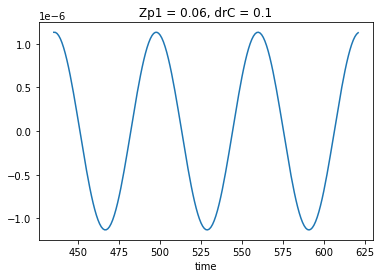

In [6]:
Frm = xr.DataArray(np.array([0.0023669,0.0076173]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                  )
aFrN = xr.DataArray(np.array([0.2,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC.isel(Zp1=slice(1,-1))
gpinv_t = (np.cos(2*np.pi*fFr_r**-1*ds.time) 
           * Frm**2 * ds.drC.isel(Zp1=slice(1,-1))**-1*aFrN*(2*np.pi*fFr_r**-1)
          )
gpinv_t.isel(Zp1=0).plot()

In [7]:
dpsib_z = -grid.diff(psib,'Z',boundary='fill').isel(Zp1=slice(1,-1))
dpsip_z = -grid.diff(psip,'Z',boundary='fill').isel(Zp1=slice(1,-1))
lapsip = (grid.diff(grid.diff(psip,'X',boundary='fill'),'X',boundary='fill')
          + grid.diff(grid.diff(psip,'Y',boundary='fill'),'Y',boundary='fill')
         ) / dx**2

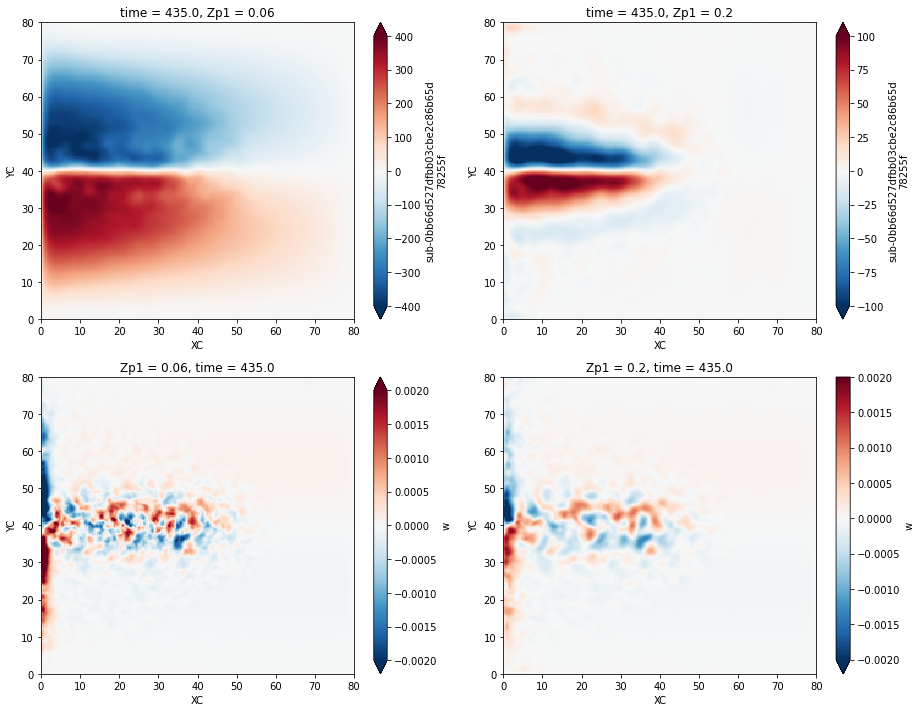

In [21]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(dpsib_z / Rom).isel(time=0,Zp1=0).plot(ax=axes[0,0], vmax=400)
(dpsib_z / Rom).isel(time=0,Zp1=1).plot(ax=axes[0,1], vmax=100)
wb.isel(time=0,Zp1=0).plot(ax=axes[1,0], vmax=0.002)
wb.isel(time=0,Zp1=1).plot(ax=axes[1,1], vmax=0.002)

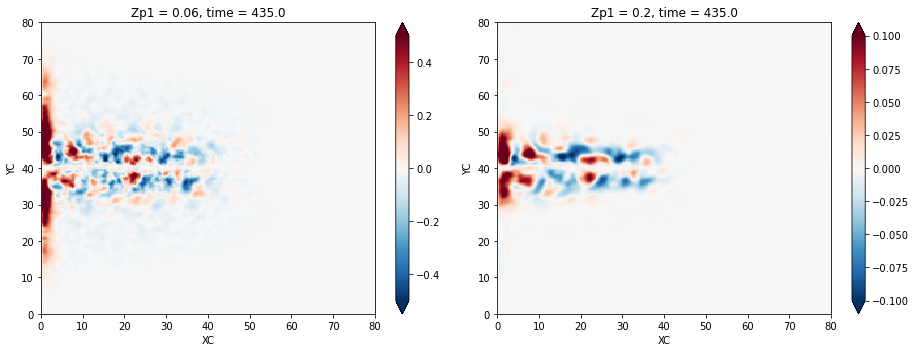

In [13]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(wb * dpsib_z / Rom).isel(time=0,Zp1=0).plot(ax=ax1, vmax=.5)
(wb * dpsib_z / Rom).isel(time=0,Zp1=1).plot(ax=ax2, vmax=.1)

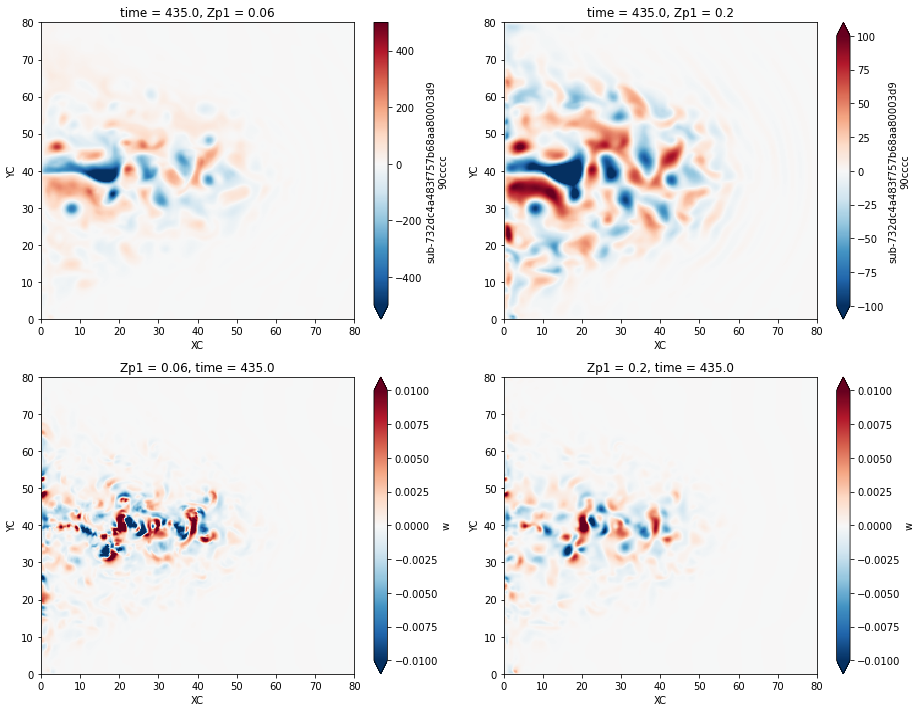

In [19]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=0).plot(ax=axes[0,0], vmax=500)
(dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=1).plot(ax=axes[0,1], vmax=100)
wp.isel(nmemb=-1,time=0,Zp1=0).plot(ax=axes[1,0], vmax=0.01)
wp.isel(nmemb=-1,time=0,Zp1=1).plot(ax=axes[1,1], vmax=0.01)

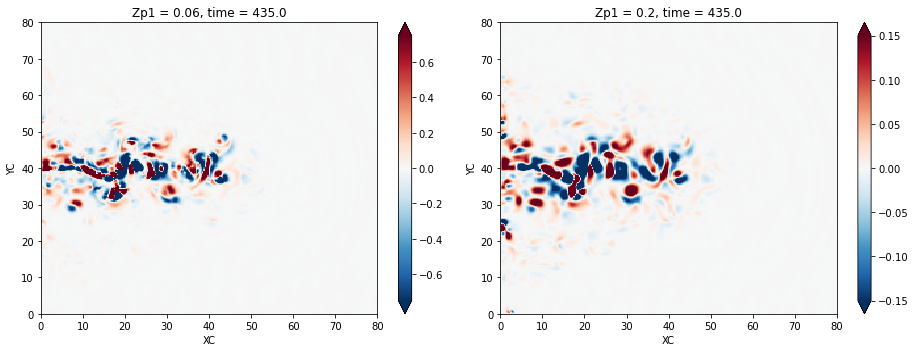

In [12]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(wp * dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=0).plot(ax=ax1, vmax=.75)
(wp * dpsip_z / Rom).isel(nmemb=-1,time=0,Zp1=1).plot(ax=ax2, vmax=.15)

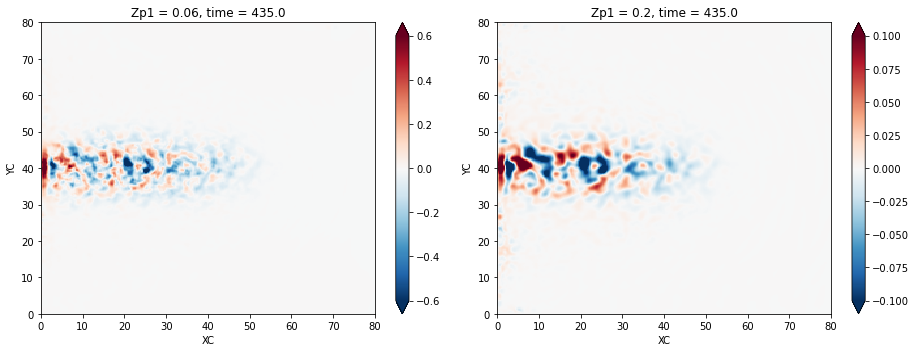

In [14]:
fig, (ax1,ax2) = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(wp * dpsip_z / Rom).isel(time=0,Zp1=0).mean('nmemb').plot(ax=ax1, vmax=.6)
(wp * dpsip_z / Rom).isel(time=0,Zp1=1).mean('nmemb').plot(ax=ax2, vmax=.1)

In [ ]:
P_K = (wb * dpsib_z).sum(['Zp1','YC','XC']).compute() * dx**2 / Rom

p_k = (wp * dpsip_z).mean('nmemb').sum(['Zp1','YC','XC']).compute() * dx**2 / Rom

K_k = (psib * (grid.interp(up,'Y',boundary='fill')
               * grid.interp(grid.diff(lapsip,'X',boundary='fill'),
                             'X',boundary='fill')
               + grid.interp(vp,'X',boundary='fill')
               * grid.interp(grid.diff(lapsip,'Y',boundary='fill'),
                             'Y',boundary='fill')
              ).mean('nmemb') / dx * ds.drF 
      ).sum(['Z','YC','XC']).compute() * dx**2
# print(P_K,p_k,K_k)

In [22]:
P_p1 = -((dpsib_z.isel(Zp1=0) * (grid.interp(up.isel(Z=0),'Y',boundary='fill').data
                                 * grid.interp(grid.diff(dpsip_z.isel(Zp1=0),'X',boundary='fill'),
                                               'X',boundary='fill')
                                 + grid.interp(vp.isel(Z=0),'X',boundary='fill').data
                                 * grid.interp(grid.diff(dpsip_z.isel(Zp1=0),'Y',boundary='fill'),
                                               'Y',boundary='fill')
                                ).mean('nmemb').data / dx
        ) / gp.isel(Zp1=0)).sum(['XC','YC']) / Rom**2
P_p3 = -((dpsib_z.isel(Zp1=-1) * (grid.interp(up.isel(Z=-1),'Y',boundary='fill').data
                                  * grid.interp(grid.diff(dpsip_z.isel(Zp1=-1),'X',boundary='fill'),
                                                'X',boundary='fill')
                                  + grid.interp(vp.isel(Z=-1),'X',boundary='fill').data
                                  * grid.interp(grid.diff(dpsip_z.isel(Zp1=-1),'Y',boundary='fill'),
                                                'Y',boundary='fill')
                                 ).mean('nmemb').data / dx
        ) / gp.isel(Zp1=-1)).sum(['XC','YC']) / Rom**2
P_p = xr.concat([P_p1,P_p3], 'Zp1').sum('Zp1').compute() * dx**2
# P_p

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [23]:
B_P = -.5*Rom**-2 * (dpsib_z.isel(Zp1=0)**2 * gpinv_t.isel(Zp1=0)
                    ).sum(['XC','YC']).compute() * dx**2
B_p = -.5*Rom**-2 * ((dpsip_z.isel(Zp1=0)**2).mean('nmemb') * gpinv_t.isel(Zp1=0)
                    ).sum(['XC','YC']).compute() * dx**2
# B_p

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


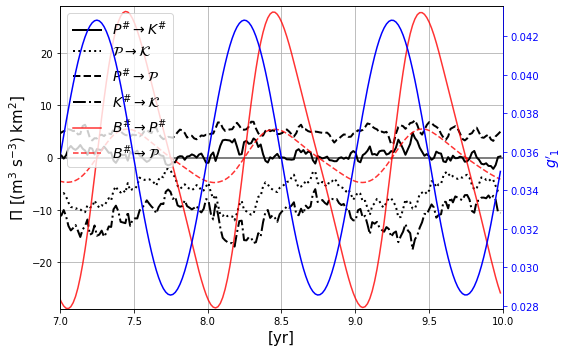

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(np.linspace(7,10,5), np.zeros(5), c='gray',
        lw=2)

ax.plot(ds.time*tau/(diny*86400), P_K*U**3/Rd*H*Rd**2 * 1e-6, 'k', lw=2,
        label=r"$P^\# \rightarrow K^\#$")
ax.plot(ds.time*tau/(diny*86400), p_k*U**3/Rd*H*Rd**2 * 1e-6, 'k:', lw=2,
        label=r"$\mathcal{P} \rightarrow \mathcal{K}$")
ax.plot(ds.time*tau/(diny*86400), P_p*U**3/Rd*H*Rd**2 * 1e-6, 'k--', lw=2,
        label=r"$P^\# \rightarrow \mathcal{P}$")
ax.plot(ds.time*tau/(diny*86400), K_k*U**3/Rd*H*Rd**2 * 1e-6, 'k-.', lw=2,
        label=r"$K^\# \rightarrow \mathcal{K}$")

ax.plot(ds.time*tau/(diny*86400), B_P*U**3/Rd*H*Rd**2 * 1e-6, c='r', alpha=.8,
        label=r"$B^\# \rightarrow P^\#$")
ax.plot(ds.time*tau/(diny*86400), B_p*U**3/Rd*H*Rd**2 * 1e-6, c='r', ls='--', alpha=.8, 
        label=r"$B^\# \rightarrow \mathcal{P}$")

ax2.plot(ds.time*tau/(diny*86400), gp.isel(Zp1=0)*U**2/H, 'b')

ax.set_xlim([7.,10.])
ax.set_ylim([-29.,29.])
ax.legend(fontsize=14, loc='upper left')
ax.set_ylabel(r"$\Pi$ [(m$^3$ s$^{-3}$) km$^2$]", fontsize=15)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.set_xlabel(r"[yr]", fontsize=15)
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/Pis_total.pdf'))

# Temporal run

<xarray.Dataset>
Dimensions:  (XC: 256, XG: 256, YC: 256, YG: 256, Z: 3, Zp1: 4, time: 187)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XG       (XG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YG       (YG) float64 0.0 0.3125 0.625 0.9375 ... 78.75 79.06 79.38 79.69
  * Z        (Z) float64 0.03 0.13 0.6
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 314.0 315.0 316.0 317.0 ... 497.0 498.0 499.0 500.0
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(6, 3, 128, 128), meta=np.ndarray>
    ptr0     (time, Z, YC, XC) float32 dask.array<chunksize=(6, 3, 128, 128), meta=np.ndarray>
    ptr1     (time, Z, YC, XC) float32 dask.array<chunksize=(6, 3, 1

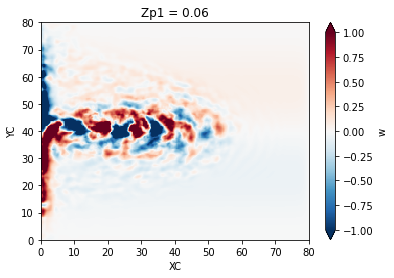

In [6]:
ntime = 187
ds = xr.open_zarr(op.join(ddir, 'run010/vars000')).isel(time=slice(-ntime,None))
dsw = xr.open_zarr(op.join(ddir, 'run010/W000'))
print(ds)

grid = Grid(ds, periodic=[],
            coords={'Z':{'center':'Z','outer':'Zp1'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
psib = ds.p.mean('time')
psip = ds.p - psib
up = -grid.diff(psip,'Y',boundary='fill') / dx
vp = grid.diff(psip,'X',boundary='fill') / dx
wb = dsw.w.mean('time')
wp = dsw.w - wb

(wb.isel(Zp1=0)*U*H/Rd*86400).plot(vmax=1.)

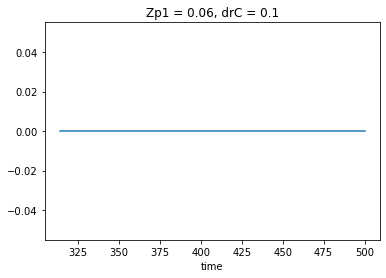

In [7]:
Frm = xr.DataArray(np.array([0.0023669,0.0076173]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                  )
aFrN = xr.DataArray(np.array([0.,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1.isel(Zp1=slice(1,-1))}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC.isel(Zp1=slice(1,-1))
gpm = Frm**-2 * ds.drC.isel(Zp1=slice(1,-1))
gpinv_t = (np.cos(2*np.pi*fFr_r**-1*ds.time) 
           * Frm**2 * ds.drC.isel(Zp1=slice(1,-1))**-1*aFrN*(2*np.pi*fFr_r**-1)
          )
gpinv_t.isel(Zp1=0).plot()

In [8]:
dpsib_z = -grid.diff(psib,'Z',boundary='fill').isel(Zp1=slice(1,-1))
dpsip_z = -grid.diff(psip,'Z',boundary='fill').isel(Zp1=slice(1,-1))
lapsip = (grid.diff(grid.diff(psip,'X',boundary='fill'),'X',boundary='fill')
          + grid.diff(grid.diff(psip,'Y',boundary='fill'),'Y',boundary='fill')
         ) / dx**2

In [9]:
P_K = 1/Rom * (wb * dpsib_z).sum(['Zp1','YC','XC']).compute() * dx**2

p_k = 1/Rom * (wp * dpsip_z).mean('time').sum(['Zp1','YC','XC']).compute() * dx**2

K_k = (psib * (grid.interp(up,'Y',boundary='fill') 
               * grid.interp(grid.diff(lapsip,'X',boundary='fill'),
                             'X',boundary='fill')
               + grid.interp(vp,'X',boundary='fill') 
               * grid.interp(grid.diff(lapsip,'Y',boundary='fill'),
                             'Y',boundary='fill')
              ).mean('time') / dx * ds.drF 
      ).sum(['Z','YC','XC']).compute() * dx**2
# print(P_K,p_k,K_k)

In [10]:
P_p1 = -((dpsib_z.isel(Zp1=0) * (grid.interp(up.isel(Z=0),'Y',boundary='fill').data
                                 * grid.interp(grid.diff(dpsip_z.isel(Zp1=0),'X',boundary='fill'),
                                               'X',boundary='fill')
                                 + grid.interp(vp.isel(Z=0),'X',boundary='fill').data
                                 * grid.interp(grid.diff(dpsip_z.isel(Zp1=0),'Y',boundary='fill'),
                                               'Y',boundary='fill')
                                ).mean('time').data / dx
        ) / gpm.isel(Zp1=0)).sum(['XC','YC']) / Rom**2
P_p3 = -((dpsib_z.isel(Zp1=-1) * (grid.interp(up.isel(Z=-1),'Y',boundary='fill').data
                                  * grid.interp(grid.diff(dpsip_z.isel(Zp1=-1),'X',boundary='fill'),
                                                'X',boundary='fill')
                                  + grid.interp(vp.isel(Z=-1),'X',boundary='fill').data
                                  * grid.interp(grid.diff(dpsip_z.isel(Zp1=-1),'Y',boundary='fill'),
                                                'Y',boundary='fill')
                                 ).mean('time').data / dx
        ) / gpm.isel(Zp1=-1)).sum(['XC','YC']) / Rom**2
P_p = xr.concat([P_p1,P_p3], 'Zp1').sum('Zp1').compute() * dx**2
# P_p

In [11]:
print(P_K, p_k, K_k, P_p)

<xarray.DataArray ()>
array(11.4883786) <xarray.DataArray ()>
array(-35.83535599) <xarray.DataArray ()>
array(-50.34503413) <xarray.DataArray ()>
array(24.7012291)
